## import libraries

In [1]:
# necessary for clustering
from clustering import clustering_temporal as ct
from clustering import clustering_spatial as cs
from RGCPD import core_pp
from RGCPD import functions_pp
from RGCPD import plot_maps as pm
import uuid
import sklearn.cluster as cluster
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

Not able to load in plotting modules, check installment of networkx


In [122]:
from sklearn.metrics import calinski_harabasz_score

In [2]:
# necessary for some operations
import numpy as np
import pandas as pd
import xarray as xr
from collections import Counter

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,7)

## define path to a small dataset

In [4]:
var_filename = 'C:\\Users\\alicj\\Desktop\\WORK\\data\\data_small.nc'
#var_filename = 'C:\\Users\\alicj\\Desktop\\WORK\\data\\data_medium.nc'
#var_filename = 'C:\\Users\\alicj\\Desktop\\WORK\\data\\mozambique_sa.nc' 

# quick test of clustering using python scripts

In [5]:
mask = None
dimension = 'temporal'
kwrgs_load={'selbox':[0, 360,-90, 90], 'tfreq':[1, 3, 4]}
kwrgs_clust={'n_clusters':[3, 4]}
clustermethodkey = 'AgglomerativeClustering'

xrclustered_temp, results_temp = ct.sklearn_clustering(var_filename, mask, dimension, kwrgs_load, clustermethodkey, kwrgs_clust)

no mask given, entire array of box [0.5, 359.5, -89.5, 89.5] will be clustered
clustering tfreq: 4, n_clusters: 4 

tfreq = 1, 2, 3, 4, 5 works, tfreq = 6 gives error

In [7]:
mask = None
dimension = 'temporal'
kwrgs_load={'selbox':[0, 360,-90, 90], 'tfreq':[4, 10]}
kwrgs_clust={'n_clusters':[3, 4]}
clustermethodkey = 'AgglomerativeClustering'

xrclustered_problem, results_problem = ct.sklearn_clustering(var_filename, mask, dimension, kwrgs_load, clustermethodkey, kwrgs_clust)

no mask given, entire array of box [0.5, 359.5, -89.5, 89.5] will be clustered
clustering tfreq: 10, n_clusters: 3 

IndexError: index 0 is out of bounds for axis 0 with size 0

In [8]:
levels = np.linspace(270, 305, 36)
levels

array([270., 271., 272., 273., 274., 275., 276., 277., 278., 279., 280.,
       281., 282., 283., 284., 285., 286., 287., 288., 289., 290., 291.,
       292., 293., 294., 295., 296., 297., 298., 299., 300., 301., 302.,
       303., 304., 305.])

Text(0.5,1,'tfreq = 1, n_clusters = 3, cluster = 1')

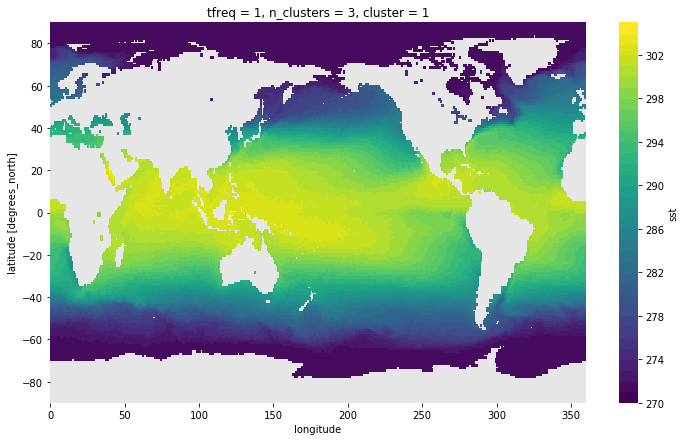

In [9]:
xrclustered_temp[0][0][np.where(xrclustered_temp[0][0]['time']['cluster'] == 1)].mean('time').plot(levels = levels)
plt.title('tfreq = {}, n_clusters = {}, cluster = 1'.format(xrclustered_temp[0][0].attrs['tfreq'], xrclustered_temp[0][0].attrs['n_clusters']))

Text(0.5,1,'tfreq = 1, n_clusters = 3, cluster = 2')

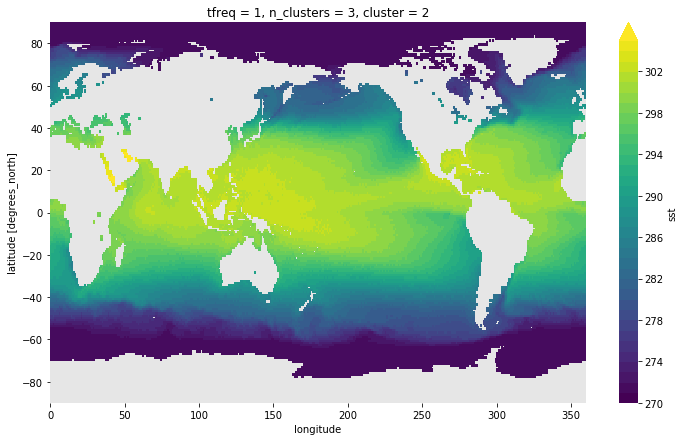

In [10]:
xrclustered_temp[0][0][np.where(xrclustered_temp[0][0]['time']['cluster'] == 2)].mean('time').plot(levels = levels)
plt.title('tfreq = {}, n_clusters = {}, cluster = 2'.format(xrclustered_temp[0][0].attrs['tfreq'], xrclustered_temp[0][0].attrs['n_clusters']))

Text(0.5,1,'tfreq = 1, n_clusters = 3, cluster = 3')

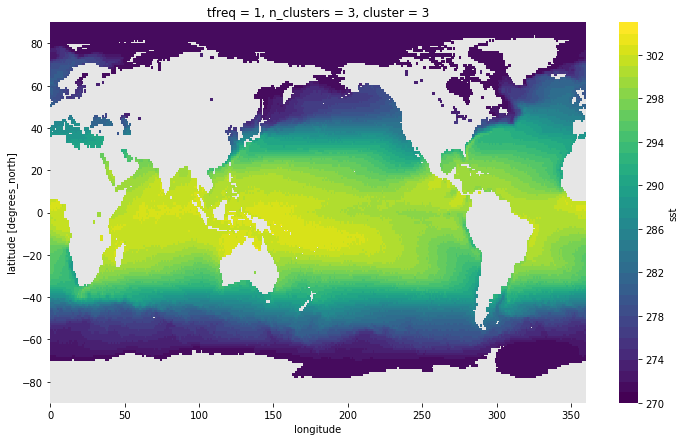

In [11]:
xrclustered_temp[0][0][np.where(xrclustered_temp[0][0]['time']['cluster'] == 3)].mean('time').plot(levels = levels)
plt.title('tfreq = {}, n_clusters = {}, cluster = 3'.format(xrclustered_temp[0][0].attrs['tfreq'], xrclustered_temp[0][0].attrs['n_clusters']))

In [12]:
mask = None
dimension = 'spatial'
kwrgs_load={'selbox':[130,160,30,50], 'tfreq':[1, 3, 4]}
kwrgs_clust={'n_clusters':[3, 4]}
clustermethodkey = 'AgglomerativeClustering'

xrclustered_spat, results_spat = ct.sklearn_clustering(var_filename, mask, dimension, kwrgs_load, clustermethodkey, kwrgs_clust)

no mask given, entire array of box [130.5, 159.5, 30.5, 49.5] will be clustered
clustering tfreq: 4, n_clusters: 4 

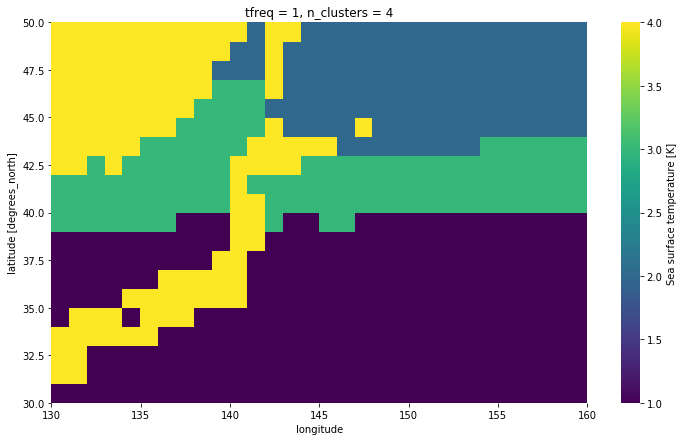

In [13]:
xrclustered_spat[0][1].plot()

## open small dataset

In [14]:
core_pp.import_ds_lazy(var_filename)

<xarray.DataArray 'sst' (time: 30, latitude: 180, longitude: 360)>
[1944000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1952-06-01
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Sea surface temperature
    units:      K

## test create_vector function 

In [15]:
time_space_3d = core_pp.import_ds_lazy(var_filename)

In [16]:
time_space_3d

<xarray.DataArray 'sst' (time: 30, latitude: 180, longitude: 360)>
[1944000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1952-06-01
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [17]:
mask = ct.get_spatial_ma(var_filename, [130,160,30,50])

In [18]:
type(mask), mask.shape

(numpy.ndarray, (180, 360))

In [19]:
sum(sum(mask == True))

600

In [20]:
space_time_vec, output_space_time, indices_mask = ct.create_vector(time_space_3d, mask)

## sklearn function for spatial and temporal clustering - old version

In [21]:
def skclustering2(time_space_3d, mask2d=None, clustermethodkey='AgglomerativeClustering',
                 kwrgs={'n_clusters':4}, dimension = 'temporal'):
    '''
    Is build upon sklean clustering. Algorithms available are listed in cluster.__dict__,
    e.g. KMeans, or AgglomerativeClustering, kwrgs are algorithms dependend.
    '''
    # ensure that the number of clusters is an integer
    if 'n_clusters' in kwrgs.keys():        
        assert isinstance(kwrgs['n_clusters'], int), 'Number of clusters is not an integer'

    algorithm = cluster.__dict__[clustermethodkey]

    cluster_method = algorithm(**kwrgs)
    space_time_vec, output_space_time, indices_mask = ct.create_vector(time_space_3d, mask2d)
    space_time_vec[np.isnan(space_time_vec)] = -32767.0 #replace nans
    
    if dimension == 'temporal':
        results = cluster_method.fit(space_time_vec.swapaxes(0, 1))
    else:
        results = cluster_method.fit(space_time_vec)
        
    labels = results.labels_ + 1
    
    # retrieving labels for spatial clustering
    if dimension == 'spatial':
        xrclustered = ct.labels_to_latlon(time_space_3d, labels, output_space_time, indices_mask, mask2d)
        return xrclustered, results
    else:
        # add labels
        coord_cluster = {'cluster':labels}
        xrclustered = time_space_3d.expand_dims(coord_cluster)
        #xrclustered = time_space_3d
        return xrclustered, results

# Cleaner version of skclustering - CURRENTLY USING THIS VERSION
additionally, cluster is not an independent dimension, but attached to time (as we need a cluster label per each time point)

In [22]:
def skclustering(time_space_3d, mask2d=None, clustermethodkey='AgglomerativeClustering',
                 kwrgs={'n_clusters':4}, dimension = 'temporal'):
    '''
    Is build upon sklean clustering. Algorithms available are listed in cluster.__dict__,
    e.g. KMeans, or AgglomerativeClustering, kwrgs are algorithms dependend.
    '''
    # ensure that the number of clusters is an integer
    if 'n_clusters' in kwrgs.keys():   
        assert isinstance(kwrgs['n_clusters'], int), 'Number of clusters is not an integer'

    algorithm = cluster.__dict__[clustermethodkey]

    cluster_method = algorithm(**kwrgs)
    print(mask2d.shape)
    print(time_space_3d.shape)
    space_time_vec, output_space_time, indices_mask = ct.create_vector(time_space_3d, mask2d)
    space_time_vec[np.isnan(space_time_vec)] = -32767.0 #replace nans
    
    if dimension == 'temporal':
        results = cluster_method.fit(space_time_vec.swapaxes(0, 1))
        labels = results.labels_ + 1
        
        # assigning cluster label to time dimension (now cluster dimension is attached to time)
        xrclustered = time_space_3d.assign_coords(cluster = ("time", labels))
        return xrclustered, results
    else:
        results = cluster_method.fit(space_time_vec)
        labels = results.labels_ + 1
        xrclustered = ct.labels_to_latlon(time_space_3d, labels, output_space_time, indices_mask, mask2d)
        return xrclustered.values, results

## test skclustering for temporal clustering

In [23]:
clustermethodkey = 'AgglomerativeClustering'
kwrgs={'n_clusters':3}
dimension = 'temporal'
mask2d = ct.get_spatial_ma(var_filename, mask = None)

no mask given, entire array of box [0.5, 359.5, -89.5, 89.5] will be clustered


In [24]:
mask2d.shape

(180, 360)

In [25]:
xrclustered_temporal, results_temporal = skclustering(time_space_3d, mask2d, clustermethodkey, kwrgs, dimension)

(180, 360)
(30, 180, 360)


In [26]:
xrclustered_temporal

<xarray.DataArray 'sst' (time: 30, latitude: 180, longitude: 360)>
[1944000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1952-06-01
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    cluster    (time) int64 3 3 3 3 1 1 2 2 2 2 1 1 ... 2 2 2 2 1 1 3 3 3 3 1 1
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [27]:
results_temporal.labels_

array([2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1,
       0, 0, 2, 2, 2, 2, 0, 0], dtype=int64)

dataframe with datetime and its cluster

In [28]:
clusters = np.array(xrclustered_temporal['cluster'])
time = np.array(xrclustered_temporal['time'])

data = {'time':time, 'cluster':clusters}
df = pd.DataFrame(data)
df[:20]

,time,cluster
0,1950-01-01,3
1,1950-02-01,3
2,1950-03-01,3
3,1950-04-01,3
4,1950-05-01,1
5,1950-06-01,1
6,1950-07-01,2
7,1950-08-01,2
8,1950-09-01,2
9,1950-10-01,2


In [29]:
xrclustered_temporal['cluster']

<xarray.DataArray 'cluster' (time: 30)>
array([3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2,
       1, 1, 3, 3, 3, 3, 1, 1], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1952-06-01
    cluster  (time) int64 3 3 3 3 1 1 2 2 2 2 1 1 3 ... 2 2 2 2 1 1 3 3 3 3 1 1

## test skclustering for spatial clustering

In [30]:
clustermethodkey = 'AgglomerativeClustering'
kwrgs={'n_clusters':3}
dimension = 'spatial'
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50])

In [31]:
xrclustered_spatial, results_spatial = skclustering(time_space_3d, mask2d, clustermethodkey, kwrgs, dimension)

(180, 360)
(30, 180, 360)


In [32]:
sum(sum(xrclustered_spatial == 3.))

256

Note that for spatial clustering sclustering returns xrclustered.values with labels for clustered coordinates

## sklearn_clustering function for spatial and temporal clustering - tfreq does not work here

In [87]:
def sklearn_clustering_old(var_filename, mask=None, 
                       dimension='temporal',
                       kwrgs_load={},
                           clustermethodkey='DBSCAN',
                           kwrgs_clust={'eps':600}):

    # kwrgs_load - keywords that we can give to load variable
    
    
    # we can either give a mask for coordinates or just select a box with coordinates
    if 'selbox' in kwrgs_load.keys():
        if kwrgs_load['selbox'] is not None:
            mask = kwrgs_load.pop('selbox')
            print('mask overwritten with selbox list. Both selbox and mask are given.'
                  'Both adapt the domain over which to cluster')
    kwrgs_l_spatial = {} # kwrgs affecting spatial extent/format
    if 'format_lon' in kwrgs_load.keys():
        kwrgs_l_spatial['format_lon'] = kwrgs_load['format_lon']

    # here we import an .nc file and convert it into an xarray object          ############### DO WE NEED IT HERE?????????????
    xarray = core_pp.import_ds_lazy(var_filename, **kwrgs_l_spatial)
    
    # here we create a numpy array mask for coordinates selected using mask (or selbox if selbox in kwrgs_load())
    npmask = ct.get_spatial_ma(var_filename, mask, kwrgs_l_spatial=kwrgs_l_spatial)

    print(kwrgs_l_spatial)
    # arguments loop
    kwrgs_loop = {k:i for k, i in kwrgs_clust.items() if type(i) == list}
    [kwrgs_loop.update({k:i}) for k, i in kwrgs_load.items() if type(i) == list]

    print("len(kwrgs_loop): {}".format(len(kwrgs_loop)))

    if len(kwrgs_loop) == 1:
        # insert fake axes
        kwrgs_loop['fake'] = [0]
        print('inserting fake axis')
    if len(kwrgs_loop) >= 1:
        print('length of kwrgs_loop is now >= 1')
        new_coords = []
        
        if dimension == 'spatial':
            xrclustered = xarray[0].drop('time')
        else: 
            xrclustered = xarray
        
        for k, list_v in kwrgs_loop.items(): # in alphabetical order
            
            # new_coords contains keys from kwrgs_clust and kwrgs_load
            new_coords.append(k)
            
            # in every iteration of the loop, we create a dictionary using key and value from kwrgs_clust and kwrgs_load
            dim_coords = {str(k):list_v}
            
            # expanding the xarray dataset by dim_coords dictionaries                                                              ######### MUST BE CHANGED - also, 2 cases for spatial and temporal clustering
            xrclustered = xrclustered.expand_dims(dim_coords).copy()
            #print(xrclustered)
        
        # create a list of coordinates/dimensions added in the for loop above (from kwrgs_clust and kwrgs_load)
        new_coords = [d for d in xrclustered.dims if d not in ['latitude', 'longitude']]
        print('new_coords', new_coords)
        print('dim_coords', dim_coords)
        results = []
        
        # separating kwrgs into lists to loop over
        first_loop = kwrgs_loop[new_coords[0]]
        second_loop = kwrgs_loop[new_coords[1]]

        
        # loop over kwrgs_load and kwrgs_clust values
        for i, v1 in enumerate(first_loop):
            for j, v2 in enumerate(second_loop):
                
                # create dictionaries of all possible combinations of kwrgs_load and kwrgs_clust ??
                kwrgs = ct.adjust_kwrgs(kwrgs_clust.copy(), new_coords, v1, v2)
                kwrgs_l = ct.adjust_kwrgs(kwrgs_load.copy(), new_coords, v1, v2)
                
                print(f"\rclustering {new_coords[0]}: {v1}, {new_coords[1]}: {v2} ", end="")
                xarray = functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_l)

                print('kwrgs that go into skclustering {}'.format(kwrgs))
                # updating xarray object and results - here change for supervised/unsupervised clustering
                xrclustered[i,j], result = skclustering(xarray, npmask,
                                                   clustermethodkey=clustermethodkey,
                                                   kwrgs=kwrgs, dimension = dimension)
                
                results.append(result)
        # unpack here (spatial-> copy from line 42-52, temporal -> copy the entire array, without dropping time)
        
        if 'fake' in new_coords:
            print('dropping fake axis')
            xrclustered = xrclustered.squeeze().drop('fake').copy() 

    else:  # so when len(kwrgs_loop) == 0:
        print('No arguments to loop over')
        xrclustered, results = skclustering(xarray, npmask,
                                            clustermethodkey=clustermethodkey,
                                            kwrgs=kwrgs_clust, dimension=dimension)
    # storing arbitrary metadata
    xrclustered.attrs['method'] = clustermethodkey
    xrclustered.attrs['kwrgs'] = str(kwrgs_clust)
    xrclustered.attrs['target'] = f'{xarray.name}'
    if 'hash' not in xrclustered.attrs.keys():
        xrclustered.attrs['hash']   = uuid.uuid4().hex[:5]
    return xrclustered, results

In [88]:
mask = None
dimension = 'temporal'
kwrgs_load={'selbox':[130,160,30,50], 'tfreq':[1, 2, 4]}
kwrgs_clust={'n_clusters':[3, 4, 5]}
clustermethodkey = 'AgglomerativeClustering'

In [89]:
xrclusteredall_test1, results_test1 = sklearn_clustering_old(var_filename, mask, dimension, kwrgs_load, clustermethodkey, kwrgs_clust)

mask overwritten with selbox list. Both selbox and mask are given.Both adapt the domain over which to cluster
{}
len(kwrgs_loop): 2
length of kwrgs_loop is now >= 1
new_coords ['tfreq', 'n_clusters', 'time']
dim_coords {'tfreq': [1, 2, 4]}
clustering tfreq: 1, n_clusters: 3 kwrgs that go into skclustering {'n_clusters': 3}
(180, 360)
(30, 180, 360)
clustering tfreq: 1, n_clusters: 4 kwrgs that go into skclustering {'n_clusters': 4}
(180, 360)
(30, 180, 360)
clustering tfreq: 1, n_clusters: 5 kwrgs that go into skclustering {'n_clusters': 5}
(180, 360)
(30, 180, 360)
clustering tfreq: 2, n_clusters: 3 kwrgs that go into skclustering {'n_clusters': 3}
(180, 360)
(14, 180, 360)


IndexError: dimension coordinate 'time' conflicts between indexed and indexing objects:
<xarray.DataArray 'time' (time: 14)>
array(['1950-04-01T00:00:00.000000000', '1950-06-01T00:00:00.000000000',
       '1950-08-01T00:00:00.000000000', '1950-10-01T00:00:00.000000000',
       '1950-12-01T00:00:00.000000000', '1951-02-01T00:00:00.000000000',
       '1951-04-01T00:00:00.000000000', '1951-06-01T00:00:00.000000000',
       '1951-08-01T00:00:00.000000000', '1951-10-01T00:00:00.000000000',
       '1951-12-01T00:00:00.000000000', '1952-02-01T00:00:00.000000000',
       '1952-04-01T00:00:00.000000000', '1952-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-04-01 1950-06-01 ... 1952-06-01
    cluster  (time) int64 3 2 1 1 2 3 3 2 1 1 2 3 3 2
vs.
<xarray.IndexVariable 'time' (time: 30)>
array(['1950-01-01T00:00:00.000000000', '1950-02-01T00:00:00.000000000',
       '1950-03-01T00:00:00.000000000', '1950-04-01T00:00:00.000000000',
       '1950-05-01T00:00:00.000000000', '1950-06-01T00:00:00.000000000',
       '1950-07-01T00:00:00.000000000', '1950-08-01T00:00:00.000000000',
       '1950-09-01T00:00:00.000000000', '1950-10-01T00:00:00.000000000',
       '1950-11-01T00:00:00.000000000', '1950-12-01T00:00:00.000000000',
       '1951-01-01T00:00:00.000000000', '1951-02-01T00:00:00.000000000',
       '1951-03-01T00:00:00.000000000', '1951-04-01T00:00:00.000000000',
       '1951-05-01T00:00:00.000000000', '1951-06-01T00:00:00.000000000',
       '1951-07-01T00:00:00.000000000', '1951-08-01T00:00:00.000000000',
       '1951-09-01T00:00:00.000000000', '1951-10-01T00:00:00.000000000',
       '1951-11-01T00:00:00.000000000', '1951-12-01T00:00:00.000000000',
       '1952-01-01T00:00:00.000000000', '1952-02-01T00:00:00.000000000',
       '1952-03-01T00:00:00.000000000', '1952-04-01T00:00:00.000000000',
       '1952-05-01T00:00:00.000000000', '1952-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

# sklearn_clustering with temporal clustering xarray saved into np.array (spatial clustering works the same)

**assert statement for kwrgs_load and kwrgs_clust**:

kwrgs_load:
- tfreq


kwrgs_clust:
- n_clusters
- affinity
- eps
- linkage

In [93]:
def sklearn_clustering(var_filename, mask=None, 
                       dimension='temporal',
                       kwrgs_load={},
                           clustermethodkey='DBSCAN',
                           kwrgs_clust={'eps':600}):

    if 'selbox' in kwrgs_load.keys(): 
        assert isinstance(kwrgs_load['selbox'], list), 'selbox is not a list'
        assert len(kwrgs_load['selbox']) == 4, 'selbox list does not have shape [lon_min, lon_max, lat_min, lat_max]'
    
    
    # we can either give a mask for coordinates or just select a box with coordinates
    if 'selbox' in kwrgs_load.keys():
        if kwrgs_load['selbox'] is not None and mask is not None:
            print('Mask overwritten with selbox list. Both selbox and mask are given.'
                    'Both adapt the domain over which to cluster')
            mask = None

    kwrgs_l_spatial = {} # kwrgs affecting spatial extent/format
    if 'format_lon' in kwrgs_load.keys():
        kwrgs_l_spatial['format_lon'] = kwrgs_load['format_lon']

    if 'selbox' in kwrgs_load.keys():
        kwrgs_l_spatial['selbox'] = kwrgs_load['selbox']

    # here we import an .nc file and convert it into an xarray object
    xarray = core_pp.import_ds_lazy(var_filename, **kwrgs_l_spatial)

    # here we create a numpy array mask for coordinates selected using mask (or selbox if selbox in kwrgs_load())
    npmask = ct.get_spatial_ma(var_filename, mask, kwrgs_l_spatial=kwrgs_l_spatial)

    print(kwrgs_l_spatial)
    # arguments loop
    kwrgs_loop = {k:i for k, i in kwrgs_clust.items() if type(i) == list}
    [kwrgs_loop.update({k:i}) for k, i in kwrgs_load.items() if type(i) == list]
    if 'selbox' in kwrgs_loop.keys():
        kwrgs_loop.pop('selbox')

    if len(kwrgs_loop) == 1:
        # insert fake axes
        kwrgs_loop['fake'] = [0]
        print('inserting fake axis')
    if len(kwrgs_loop) >= 1:
        #print('length of kwrgs_loop is now >= 1')
        new_coords = []
        
        if dimension == 'spatial':
            xrclustered = xarray[0].drop('time')
        else: 
            xrclustered = xarray
        
        for k, list_v in kwrgs_loop.items(): # in alphabetical order
            
            # new_coords contains keys from kwrgs_clust and kwrgs_load
            new_coords.append(k)
            
            # in every iteration of the loop, we create a dictionary using key and value from kwrgs_clust and kwrgs_load
            dim_coords = {str(k):list_v}
            
            # expanding the xarray dataset by dim_coords dictionaries                                                       
            xrclustered = xrclustered.expand_dims(dim_coords).copy()
            #print(xrclustered)
        
        # create a list of coordinates/dimensions added in the for loop above (from kwrgs_clust and kwrgs_load)
        new_coords = [d for d in xrclustered.dims if d not in ['latitude', 'longitude', 'time']] 

        
        # to store sklearn objects
        results = []
        
        # separating kwrgs into lists to loop over
        first_loop = kwrgs_loop[new_coords[0]]
        second_loop = kwrgs_loop[new_coords[1]]
      
        if dimension == 'temporal':
            xr_temporal = np.empty([len(first_loop), len(second_loop)], dtype=object)
    
        # if kwrgs_load is empty we can load in the xarray here -> it won't be changing
        
        # loop over kwrgs_load and kwrgs_clust values
        for i, v1 in enumerate(first_loop):
            for j, v2 in enumerate(second_loop):
                
                # create dictionaries of all possible combinations of kwrgs_load and kwrgs_clust ??
                kwrgs = ct.adjust_kwrgs(kwrgs_clust.copy(), new_coords, v1, v2)
                
                # if we don't have any kwrgs_load we don't need it -> add an if statement for memory optimization
                # and add the 5 lines below into the if statement
                kwrgs_l = ct.adjust_kwrgs(kwrgs_load.copy(), new_coords, v1, v2)

                if 'tfreq' in kwrgs_l.keys():
                    assert isinstance(kwrgs_l['tfreq'], int), 'tfreq is not an integer'
                    #print(kwrgs_l['tfreq'])
                
                print(f"\rclustering {new_coords[0]}: {v1}, {new_coords[1]}: {v2} ", end="")
                xarray = functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_l)
                

                #print('kwrgs that go into skclustering {}'.format(kwrgs))
                # updating xarray object and results - here change for supervised/unsupervised clustering
                if dimension == 'spatial':
                    xrclustered[i,j], result = skclustering(xarray, npmask,
                                                   clustermethodkey=clustermethodkey,
                                                   kwrgs=kwrgs, dimension = dimension)
                else:
                    xr_temporal[i, j], result = skclustering(xarray, npmask,
                                                   clustermethodkey=clustermethodkey,
                                                   kwrgs=kwrgs, dimension = dimension)
                    #print('kwrgs', kwrgs)
                    # storing arbitrary metadata for temporal clustering
                    xr_temporal[i,j].attrs['method'] = clustermethodkey
                    xr_temporal[i,j].attrs['target'] = f'{xarray.name}'
                    if new_coords[0] != 'fake':
                        xr_temporal[i,j].attrs[new_coords[0]] = v1
                    xr_temporal[i,j].attrs[new_coords[1]] = v2
                    if 'hash' not in xr_temporal[i,j].attrs.keys():
                        xr_temporal[i,j].attrs['hash']   = uuid.uuid4().hex[:5]
                        
                    
                
                results.append(result)
        
        if 'fake' in new_coords and dimension == 'spatial':
            print('dropping fake axis')
            # separate for spatial and temporal?
            xrclustered = xrclustered.squeeze().drop('fake').copy() 

    else:  # so when len(kwrgs_loop) == 0:
        print('No arguments to loop over')
        xrclustered, results = skclustering(xarray, npmask,
                                            clustermethodkey=clustermethodkey,
                                            kwrgs=kwrgs_clust, dimension=dimension)
        return xrclustered, results
    
    # storing arbitrary metadata for spatial clustering
    xrclustered.attrs['method'] = clustermethodkey
    xrclustered.attrs['kwrgs'] = str(kwrgs_clust)
    xrclustered.attrs['target'] = f'{xarray.name}'
    if 'hash' not in xrclustered.attrs.keys():
        xrclustered.attrs['hash']   = uuid.uuid4().hex[:5]
    
    if dimension == 'temporal':
        return xr_temporal, results
    # dimension == 'spatial'  
    else:
        return xrclustered, results

## test sklearn_clustering for temporal clustering

In [94]:
mask = None
dimension = 'temporal'
kwrgs_load={'selbox':[130,160,30,50], 'tfreq':[1, 2, 4]}
#kwrgs_load={}

# Agglomerative clustering -> uses predefined number of clusters
#kwrgs_clust={'n_clusters':[3, 4], 'affinity': 'manhattan', 'linkage':'average'}
#kwrgs_clust={'n_clusters':3}
kwrgs_clust={'n_clusters':[3, 4, 5]}
clustermethodkey = 'AgglomerativeClustering'

# DBSCAN -> eps: how close points should be to each other to be a part of one cluster; eps between 40/60 seemed okay for temporal clustering
# kwrgs_clust={'eps':[40, 50, 55]}
# clustermethodkey = 'DBSCAN'

# kMeans
#kwrgs_clust = {'n_clusters':[3, 4, 5]}
# kwrgs_clust = {'n_clusters':[3, 4]}
# clustermethodkey = 'KMeans'


print('kwrgs_clust: {}'.format(kwrgs_clust))
print('kwrgs_load: {}'.format(kwrgs_load))
print('dimenion: {}'.format(dimension))
print('clustermethodkey: {}'.format(clustermethodkey))

kwrgs_clust: {'n_clusters': [3, 4, 5]}
kwrgs_load: {'selbox': [130, 160, 30, 50], 'tfreq': [1, 2, 4]}
dimenion: temporal
clustermethodkey: AgglomerativeClustering


In [95]:
xrclusteredall_t, results_t = sklearn_clustering(var_filename, mask, dimension, kwrgs_load, clustermethodkey, kwrgs_clust)

no mask given, entire array of box [130.5, 159.5, 30.5, 49.5] will be clustered
{'selbox': [130, 160, 30, 50]}
clustering tfreq: 1, n_clusters: 3 (20, 30)
(30, 20, 30)
clustering tfreq: 1, n_clusters: 4 (20, 30)
(30, 20, 30)
clustering tfreq: 1, n_clusters: 5 (20, 30)
(30, 20, 30)
clustering tfreq: 2, n_clusters: 3 (20, 30)
(14, 20, 30)
clustering tfreq: 2, n_clusters: 4 (20, 30)
(14, 20, 30)
clustering tfreq: 2, n_clusters: 5 (20, 30)
(14, 20, 30)
clustering tfreq: 4, n_clusters: 3 (20, 30)
(7, 20, 30)
clustering tfreq: 4, n_clusters: 4 (20, 30)
(7, 20, 30)
clustering tfreq: 4, n_clusters: 5 (20, 30)
(7, 20, 30)


In [63]:
xrclusteredall_t.shape

(3, 3)

In [64]:
xrclusteredall_t.shape

(3, 3)

In [65]:
xrclusteredall_t.shape  # for agglomerative clustering: 3 tfreq values, 2 n_clusters values

(3, 3)

In [66]:
xrclusteredall_t[0][0]

<xarray.DataArray 'sst' (time: 30, latitude: 20, longitude: 30)>
array([[[292.92288, 293.6093 , ..., 291.75455, 291.6277 ],
        [      nan,       nan, ..., 290.8678 , 290.84656],
        ...,
        [      nan,       nan, ..., 274.60806, 275.08936],
        [      nan,       nan, ..., 274.44116, 274.4205 ]],

       [[292.01855, 292.82455, ..., 291.7855 , 291.5852 ],
        [      nan,       nan, ..., 290.8927 , 291.02924],
        ...,
        [      nan,       nan, ..., 274.1577 , 274.37015],
        [      nan,       nan, ..., 274.14194, 274.00415]],

       ...,

       [[295.6814 , 296.80786, ..., 294.49786, 294.62714],
        [      nan,       nan, ..., 293.616  , 293.42117],
        ...,
        [      nan,       nan, ..., 275.00986, 274.9358 ],
        [      nan,       nan, ..., 274.2433 , 274.61716]],

       [[298.1601 , 299.05292, ..., 297.61813, 297.74194],
        [      nan,       nan, ..., 296.25192, 296.29865],
        ...,
        [      nan,       nan, ..., 277.159  , 277.20877],
        [      nan,       nan, ..., 276.82034, 277.0364 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1952-06-01
  * longitude  (longitude) float64 130.5 131.5 132.5 133.5 ... 157.5 158.5 159.5
  * latitude   (latitude) float64 30.5 31.5 32.5 33.5 ... 46.5 47.5 48.5 49.5
    cluster    (time) int64 1 1 1 1 1 2 3 3 3 2 2 1 ... 2 3 3 2 2 1 1 1 1 1 1 2
Attributes:
    long_name:   Sea surface temperature
    units:       K
    method:      AgglomerativeClustering
    target:      sst
    tfreq:       1
    n_clusters:  3
    hash:        c467d

In [67]:
selbox = [30, 50, 130, 160]

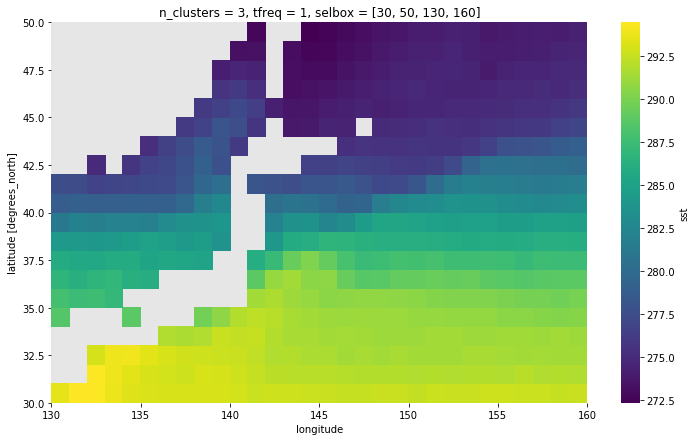

In [68]:
fig, ax = plt.subplots(1, 1)
xrclusteredall_t[0][0][np.where(xrclusteredall_t[0][0]['time']['cluster'] == 1)].mean('time').plot(ax = ax)
plt.title('n_clusters = {}, tfreq = {}, selbox = {}'.format(xrclusteredall_t[0][0].attrs['n_clusters'], xrclusteredall_t[0][0].attrs['tfreq'], selbox));

# Agglomerative/kMeans: Example of plotting the modes of temporal variability (3 clusters and tfreq = 2)

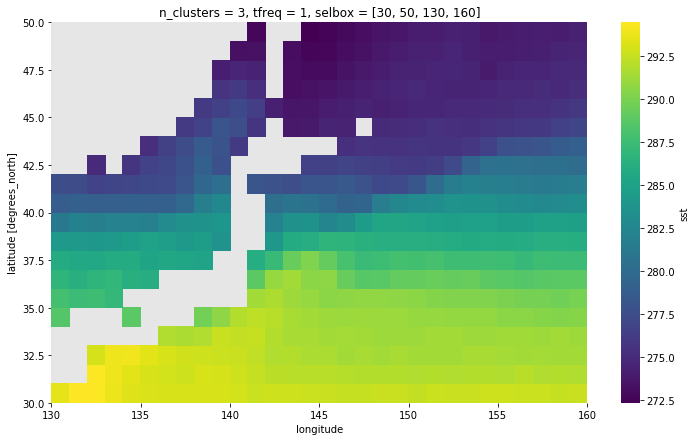

In [69]:
fig, ax = plt.subplots(1, 1)
xrclusteredall_t[0][0][np.where(xrclusteredall_t[0][0]['time']['cluster'] == 1)].mean('time').plot(ax = ax)
plt.title('n_clusters = {}, tfreq = {}, selbox = {}'.format(xrclusteredall_t[0][0].attrs['n_clusters'], xrclusteredall_t[0][0].attrs['tfreq'], selbox));

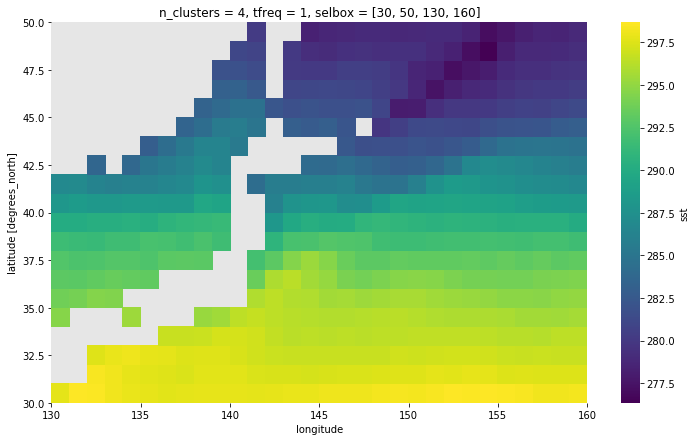

In [70]:
fig, ax = plt.subplots(1, 1)
xrclusteredall_t[0][1][np.where(xrclusteredall_t[0][1]['time']['cluster'] == 1)].mean('time').plot(ax = ax)
plt.title('n_clusters = {}, tfreq = {}, selbox = {}'.format(xrclusteredall_t[0][1].attrs['n_clusters'], xrclusteredall_t[0][1].attrs['tfreq'], selbox));

# plotting
- add titles to individual plots
- set the colorbar to be the same for all plots (to make them easy to compare)

In [71]:
levels = np.linspace(265, 310, 46)

Text(0.5,0.98,'n_clusters = 3, tfreq = 1')

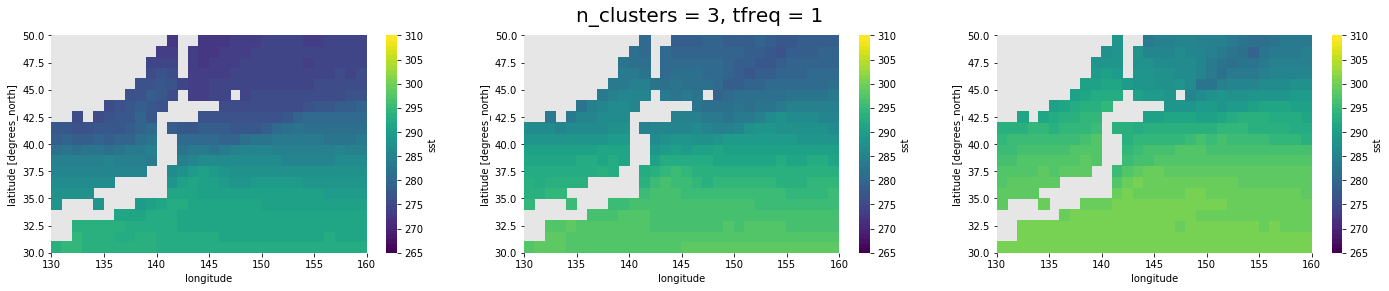

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(24, 4))
xrclusteredall_t[0][0][np.where(xrclusteredall_t[0][0]['time']['cluster'] == 1)].mean('time').plot(ax = axs[0], levels = levels)
xrclusteredall_t[0][0][np.where(xrclusteredall_t[0][0]['time']['cluster'] == 2)].mean('time').plot(ax = axs[1], levels = levels)
xrclusteredall_t[0][0][np.where(xrclusteredall_t[0][0]['time']['cluster'] == 3)].mean('time').plot(ax = axs[2], levels = levels)
fig.suptitle("n_clusters = {}, tfreq = {}".format(xrclusteredall_t[0][0].attrs['n_clusters'], xrclusteredall_t[0][0].attrs['tfreq']), size = 20)

Text(0.5,0.98,'n_clusters = 4, tfreq = 1')

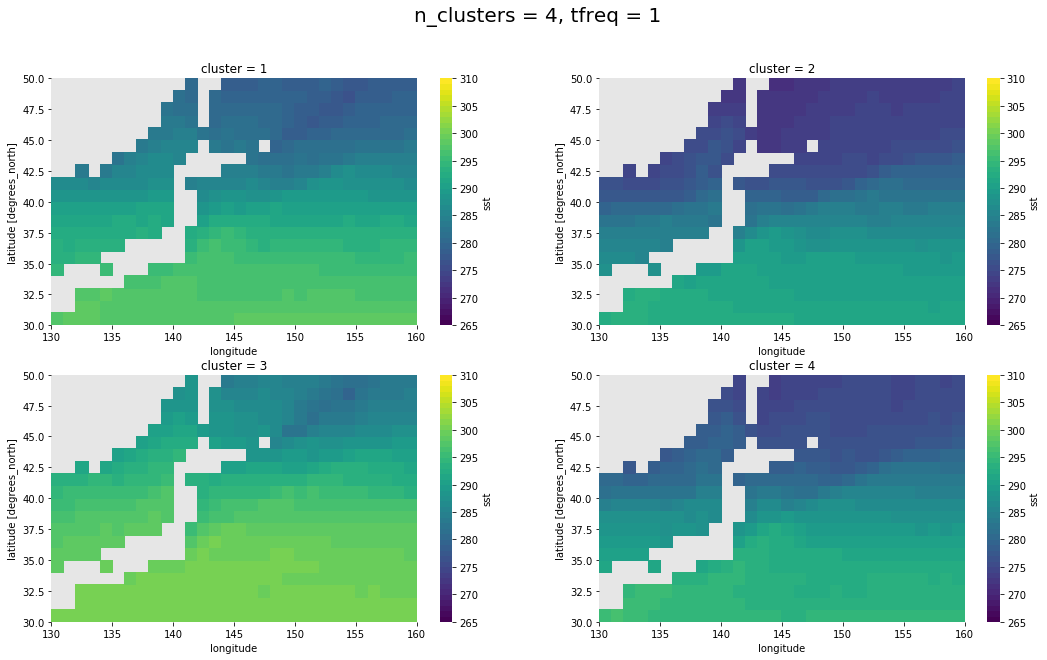

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
xrclusteredall_t[0][1][np.where(xrclusteredall_t[0][1]['time']['cluster'] == 1)].mean('time').plot(ax = axs[0, 0], levels = levels)
axs[0, 0].set_title('cluster = 1')
xrclusteredall_t[0][1][np.where(xrclusteredall_t[0][1]['time']['cluster'] == 2)].mean('time').plot(ax = axs[0, 1], levels = levels)
axs[0, 1].set_title('cluster = 2')
xrclusteredall_t[0][1][np.where(xrclusteredall_t[0][1]['time']['cluster'] == 3)].mean('time').plot(ax = axs[1, 0], levels = levels)
axs[1, 0].set_title('cluster = 3')
xrclusteredall_t[0][1][np.where(xrclusteredall_t[0][1]['time']['cluster'] == 4)].mean('time').plot(ax = axs[1, 1], levels = levels)
axs[1, 1].set_title('cluster = 4')
fig.suptitle("n_clusters = {}, tfreq = {}".format(xrclusteredall_t[0][1].attrs['n_clusters'], xrclusteredall_t[0][1].attrs['tfreq']), size = 20)

In [74]:
print('tfreq = {}, counts: {}'.format(xrclusteredall_t[0][0].attrs['tfreq'], Counter(results_t[0].labels_+1)))  # n_clusters = 3
print('tfreq = {}, counts: {}'.format(xrclusteredall_t[0][1].attrs['tfreq'], Counter(results_t[1].labels_+1)))  # n_clusters = 4
print('tfreq = {}, counts: {}'.format(xrclusteredall_t[1][0].attrs['tfreq'], Counter(results_t[2].labels_+1)))  # n_clusters = 3
print('tfreq = {}, counts: {}'.format(xrclusteredall_t[1][1].attrs['tfreq'], Counter(results_t[3].labels_+1)))  # n_clusters = 4
print('tfreq = {}, counts: {}'.format(xrclusteredall_t[2][0].attrs['tfreq'], Counter(results_t[4].labels_+1)))  # n_clusters = 3
print('tfreq = {}, counts: {}'.format(xrclusteredall_t[2][1].attrs['tfreq'], Counter(results_t[5].labels_+1)))  # n_clusters = 4

tfreq = 1, counts: Counter({1: 17, 2: 8, 3: 5})
tfreq = 1, counts: Counter({2: 12, 1: 8, 4: 5, 3: 5})
tfreq = 2, counts: Counter({2: 12, 4: 5, 3: 5, 1: 5, 5: 3})
tfreq = 2, counts: Counter({3: 5, 2: 5, 1: 4})
tfreq = 4, counts: Counter({3: 5, 1: 5, 2: 3, 4: 1})
tfreq = 4, counts: Counter({3: 5, 5: 3, 1: 3, 2: 2, 4: 1})


## functions for easy plotting of temporal clustering results

for plotting one cluster for all parameter configurations from `sklearn_clustering`

In [75]:
def plotting_cluster(xrclustered, cluster, figsize = (20, 16)):
    """
    xrclustered: numpy array of xarray.DataArray objects
        numpy array of temporally clustered xarray data
    cluster: int
        cluster label which we want to plot (plots of the same cluster for different kwrgs_clust and kwrgs_load configurations)
    """
    levels = np.linspace(265, 310, 46)
    ncols = xrclustered.shape[1]
    nrows = xrclustered.shape[0]

    fig, axs = plt.subplots(nrows, ncols, figsize = figsize)
    for row in range(nrows):
        for col in range(ncols):
            xrclustered[row][col][np.where(xrclustered[row][col]['time']['cluster'] == cluster)].mean('time').plot(ax = axs[row, col], levels = levels)
            axs[row, col].set_title('tfreq = {}, n_clusters = {}'.format(xrclustered[row][col].attrs['tfreq'], xrclustered[row][col].attrs['n_clusters']))
    fig.suptitle('Patterns for cluster label = {}'.format(cluster), size = 20)

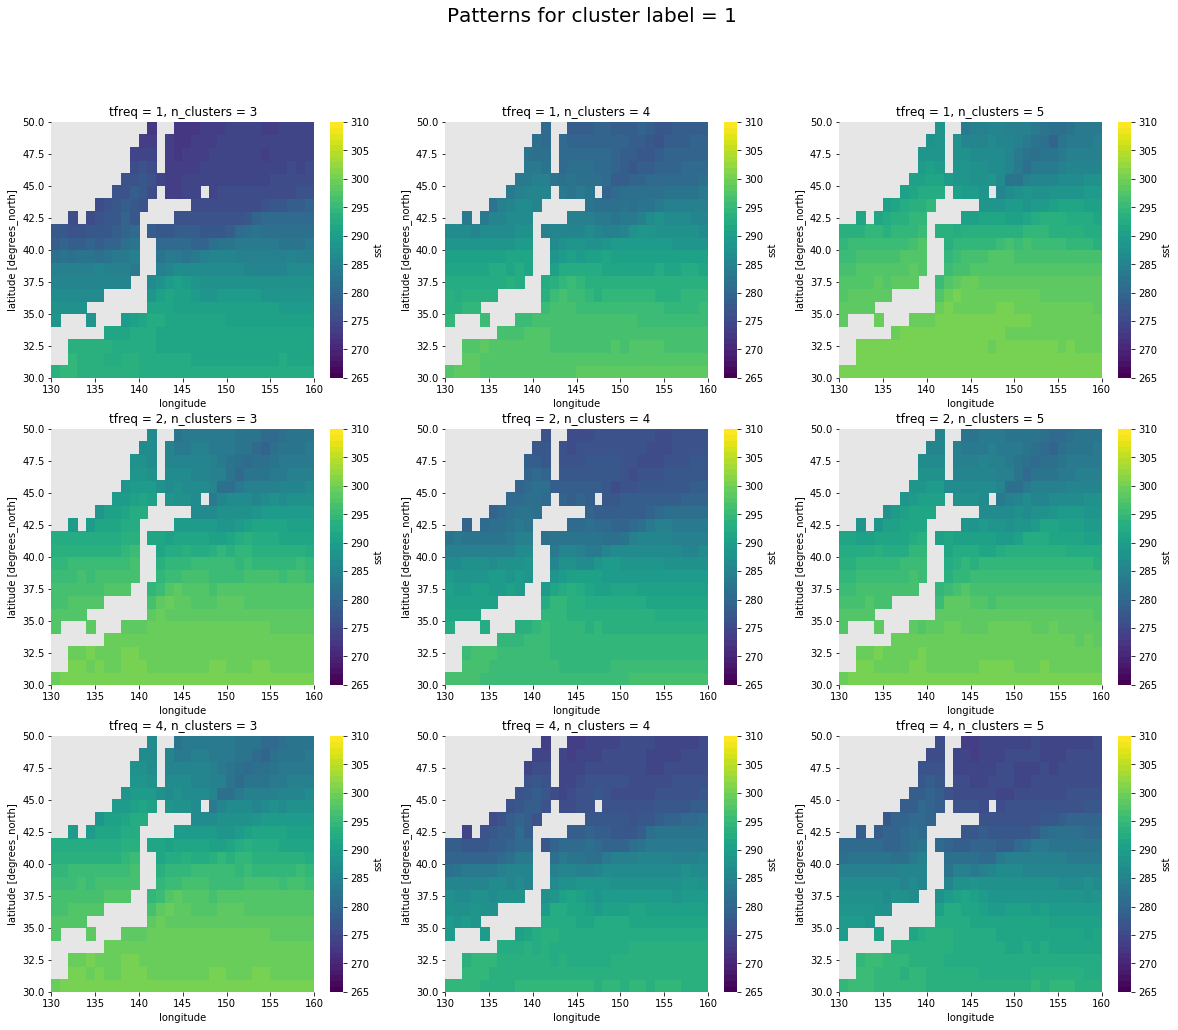

In [76]:
plotting_cluster(xrclusteredall_t, 1)

for plotting all clusters for one parameter configuration

In [77]:
def plotting_params(xrclustered, figsize = (16, 11)):
    """ 
    xrclustered: xarray.DataArray
        an object from the numpy array of xarray objects (xarray with specific parameter configuration)
    """
    levels = np.linspace(265, 310, 46)
    nclusters = xrclustered.attrs['n_clusters']
    fig, axs = plt.subplots(nclusters, figsize = figsize)
    for cluster in range(nclusters):
        xrclustered[np.where(xrclustered['time']['cluster'] == cluster+1)].mean('time').plot(ax = axs[cluster], levels = levels)
        axs[cluster].set_title('cluster label = {}'.format(cluster+1))
    fig.suptitle('Patterns for tfreq = {}, n_clusters = {}'.format(xrclustered.attrs['tfreq'], nclusters), size = 20)

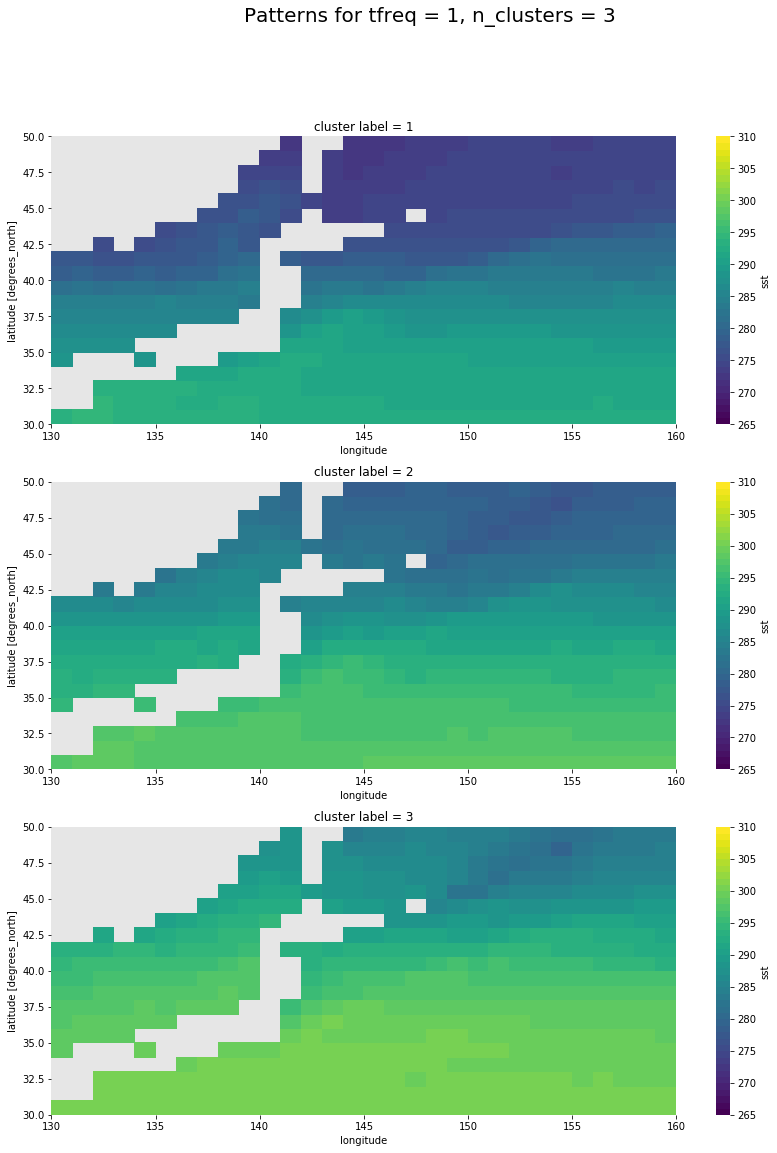

In [78]:
plotting_params(xrclusteredall_t[0][0], figsize = (14, 18))

## define variables needed for evaluation metrics

In [79]:
kwrgs_loop = {k:i for k, i in kwrgs_clust.items() if type(i) == list}
[kwrgs_loop.update({k:i}) for k, i in kwrgs_load.items() if type(i) == list]

[None, None]

In [80]:
# Agglomerative clustering, 
new_coords = ['tfreq', 'n_clusters']

# DBSCAN
#new_coords = ['tfreq', 'eps']

first_loop = kwrgs_loop[new_coords[0]]
second_loop = kwrgs_loop[new_coords[1]]

kwrgs_list = []
for i, v1 in enumerate(first_loop):
            for j, v2 in enumerate(second_loop):
                kwrgs_l = ct.adjust_kwrgs(kwrgs_load.copy(), new_coords, v1, v2)
                print(kwrgs_l)
                kwrgs_list.append(kwrgs_l)

{'selbox': [130, 160, 30, 50], 'tfreq': 1}
{'selbox': [130, 160, 30, 50], 'tfreq': 1}
{'selbox': [130, 160, 30, 50], 'tfreq': 1}
{'selbox': [130, 160, 30, 50], 'tfreq': 2}
{'selbox': [130, 160, 30, 50], 'tfreq': 2}
{'selbox': [130, 160, 30, 50], 'tfreq': 2}
{'selbox': [130, 160, 30, 50], 'tfreq': 4}
{'selbox': [130, 160, 30, 50], 'tfreq': 4}
{'selbox': [130, 160, 30, 50], 'tfreq': 4}


In [81]:
results_t

[AgglomerativeClustering(n_clusters=3),
 AgglomerativeClustering(n_clusters=4),
 AgglomerativeClustering(n_clusters=5),
 AgglomerativeClustering(n_clusters=3),
 AgglomerativeClustering(n_clusters=4),
 AgglomerativeClustering(n_clusters=5),
 AgglomerativeClustering(n_clusters=3),
 AgglomerativeClustering(n_clusters=4),
 AgglomerativeClustering(n_clusters=5)]

#### for tfreq = 1

In [84]:
# mask2d must be the same as selbox
time_space_3d_1 = core_pp.import_ds_lazy(var_filename)
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50])
space_time_vec_1, _, _ = ct.create_vector(time_space_3d_1, mask2d)
space_time_vec_1[np.isnan(space_time_vec_1)] = -32767.0 #replace nans

#### for tfreq = 1 (subscript _1), 2 (subscript _2), 4 (subscript _4)

for agglomerative/KMeans we only need kwrgs_list where tfreq is different, so we only use indices 0, 2, 4; for DBSCAN we need 0, 3, 6

In [85]:
time_space_3d_1.shape, mask2d.shape

((30, 180, 360), (180, 360))

# After adding mask to sklearn_clustering we need to add selbox to get_spatial_ma to get the correct shape, otherwise create_vector does not work

In [96]:
kwrgs_l_spatial = {}
if 'selbox' in kwrgs_load.keys():
        kwrgs_l_spatial['selbox'] = kwrgs_load['selbox']

kwrgs_l_spatial

{'selbox': [130, 160, 30, 50]}

In [101]:
kwrgs_list

[{'selbox': [130, 160, 30, 50], 'tfreq': 1},
 {'selbox': [130, 160, 30, 50], 'tfreq': 1},
 {'selbox': [130, 160, 30, 50], 'tfreq': 1},
 {'selbox': [130, 160, 30, 50], 'tfreq': 2},
 {'selbox': [130, 160, 30, 50], 'tfreq': 2},
 {'selbox': [130, 160, 30, 50], 'tfreq': 2},
 {'selbox': [130, 160, 30, 50], 'tfreq': 4},
 {'selbox': [130, 160, 30, 50], 'tfreq': 4},
 {'selbox': [130, 160, 30, 50], 'tfreq': 4}]

In [103]:
# mask2d must be the same as selbox
time_space_3d_1 = functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_list[0])
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50], kwrgs_l_spatial)
space_time_vec_1, _, _ = ct.create_vector(time_space_3d_1, mask2d)
space_time_vec_1[np.isnan(space_time_vec_1)] = -32767.0 #replace nans

In [104]:
# mask2d must be the same as selbox
time_space_3d_2 = functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_list[3]) #  2 for agglomerative/kmeans, 3 for dbscan
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50], kwrgs_l_spatial)
space_time_vec_2, _, _ = ct.create_vector(time_space_3d_2, mask2d)
space_time_vec_2[np.isnan(space_time_vec_2)] = -32767.0 #replace nans

In [105]:
# mask2d must be the same as selbox
time_space_3d_4 = functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_list[6]) # 4 for agglomerative/kmeans, 6 for dbscan
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50], kwrgs_l_spatial)
space_time_vec_4, _, _ = ct.create_vector(time_space_3d_4, mask2d)
space_time_vec_4[np.isnan(space_time_vec_4)] = -32767.0 #replace nans

In [106]:
space_time_vec_1.shape, space_time_vec_2.shape, space_time_vec_4.shape  # tfreq = 1, tfreq = 2, tfreq = 4

((600, 30), (600, 14), (600, 7))

## Agglomerative clustering

In [107]:
# Agglomerative clustering
dic1_a = Counter(results_t[0].labels_)
dic2_a = Counter(results_t[1].labels_)
#dic3_a = {i+1:list(results_t[2].labels_+1).count(i+1) for i in list(results_t[2].labels_)}

results_t[0].labels_+1, results_t[1].labels_+1#, results_t[2].labels_+1

(array([1, 1, 1, 1, 1, 2, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 2,
        2, 1, 1, 1, 1, 1, 1, 2], dtype=int64),
 array([2, 2, 2, 2, 4, 1, 3, 3, 3, 1, 1, 4, 2, 2, 2, 2, 4, 1, 1, 3, 3, 1,
        1, 4, 2, 2, 2, 2, 4, 1], dtype=int64))

In [108]:
#print('Agglomerative cluster sizes: n_clusters = 3 {}, n_clusters = 4 {}, n_clusters = 5 {}'.format(dic1_a, dic2_a, dic3_a))
print('Agglomerative cluster sizes: n_clusters = 3 {}, n_clusters = 4 {}'.format(dic1_a, dic2_a))

Agglomerative cluster sizes: n_clusters = 3 Counter({0: 17, 1: 8, 2: 5}), n_clusters = 4 Counter({1: 12, 0: 8, 3: 5, 2: 5})


In [109]:
clustermethodkey

'AgglomerativeClustering'

In [115]:
results_t

[AgglomerativeClustering(n_clusters=3),
 AgglomerativeClustering(n_clusters=4),
 AgglomerativeClustering(n_clusters=5),
 AgglomerativeClustering(n_clusters=3),
 AgglomerativeClustering(n_clusters=4),
 AgglomerativeClustering(n_clusters=5),
 AgglomerativeClustering(n_clusters=3),
 AgglomerativeClustering(n_clusters=4),
 AgglomerativeClustering(n_clusters=5)]

# evaluation

## Davies-Boudlin score - indicates separation between the clusters, the lower the score, the better the separation

In [112]:
# davies bouldin score - indicates separation between the clusters; the lower the better
# n_clusters = 3
db_a1 = davies_bouldin_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1)  # tfreq = 1
db_a2 = davies_bouldin_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1)  # tfreq = 2
db_a3 = davies_bouldin_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)  # tfreq = 4

# n_clusters = 4
# db_a1 = davies_bouldin_score(space_time_vec_1.swapaxes(0,1), results_t[1].labels_+1)
# db_a2 = davies_bouldin_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1)
# db_a3 = davies_bouldin_score(space_time_vec_4.swapaxes(0,1), results_t[5].labels_+1)


db_a1, db_a2, db_a3


(0.5150254746767998, 0.2792524391663775, 0.5087338761742535)

In [113]:
print('davies bouldin score Agglomerative n_clusters = 3: tfreq = 1 {}, tfreq = 2 {}, tfreq 4 = {}'.format(db_a1, db_a2, db_a3))
#print('davies bouldin score Agglomerative n_clusters = 4: tfreq = 1 {}, tfreq = 2 {}, tfreq 4 = {}'.format(db_a1, db_a2, db_a3))

davies bouldin score Agglomerative n_clusters = 3: tfreq = 1 0.5150254746767998, tfreq = 2 0.2792524391663775, tfreq 4 = 0.5087338761742535


## silhouette coefficient - a higher score relates to a model with better defined clusters

In [121]:
silhouette_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1), silhouette_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1), silhouette_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)

(0.60009575, 0.77413094, 0.53790003)

## Calinski-Harabasz index - the score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster

In [125]:
calinski_harabasz_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1), calinski_harabasz_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1), calinski_harabasz_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)

(112.07364907649415, 178.63182163930847, 180.31137541501852)

## DBSCAN

In [116]:
# DBSCAN
# eps = 40
# dic1_d = {i+1:list(results_t[0].labels_+1).count(i+1) for i in list(results_t[0].labels_)}
# dic2_d = {i+1:list(results_t[3].labels_+1).count(i+1) for i in list(results_t[3].labels_)}
# dic3_d = {i+1:list(results_t[6].labels_+1).count(i+1) for i in list(results_t[6].labels_)}
# results_t[0].labels_+1, list(results_t[0].labels_+1).count(0), results_t[3].labels_+1, list(results_t[3].labels_+1).count(0), results_t[6].labels_+1, list(results_t[6].labels_+1).count(0) # or add 1 and count 0's

# # eps = 50
# dic1_d = {i+1:list(results_t[1].labels_+1).count(i+1) for i in list(results_t[1].labels_)}
# dic2_d = {i+1:list(results_t[4].labels_+1).count(i+1) for i in list(results_t[4].labels_)}
# dic3_d = {i+1:list(results_t[7].labels_+1).count(i+1) for i in list(results_t[7].labels_)}
# results_t[1].labels_+1, list(results_t[1].labels_+1).count(0), results_t[4].labels_+1, list(results_t[4].labels_+1).count(0), results_t[7].labels_+1, list(results_t[7].labels_+1).count(0) # or add 1 and count 0's

# # eps = 55
dic1_d = {i+1:list(results_t[2].labels_+1).count(i+1) for i in list(results_t[2].labels_)}
dic2_d = {i+1:list(results_t[5].labels_+1).count(i+1) for i in list(results_t[5].labels_)}
dic3_d = {i+1:list(results_t[8].labels_+1).count(i+1) for i in list(results_t[8].labels_)}
results_t[2].labels_+1, list(results_t[2].labels_+1).count(0), results_t[5].labels_+1, list(results_t[5].labels_+1).count(0), results_t[7].labels_+1, list(results_t[7].labels_+1).count(0) # or add 1 and count 0's

# label 0 -> outlier

(array([2, 2, 2, 2, 4, 3, 1, 1, 1, 5, 3, 4, 2, 2, 2, 2, 4, 3, 5, 1, 1, 5,
        3, 4, 2, 2, 2, 2, 4, 3], dtype=int64),
 0,
 array([3, 5, 4, 1, 2, 3, 3, 5, 1, 1, 2, 3, 3, 5], dtype=int64),
 0,
 array([3, 4, 1, 3, 2, 1, 3], dtype=int64),
 0)

In [117]:
print('DBSCAN cluster sizes: eps = 40 {}, eps = 50 {}, eps = 55 {}'.format(dic1_d, dic2_d, dic3_d))

DBSCAN cluster sizes: eps = 40 {2: 12, 4: 5, 3: 5, 1: 5, 5: 3}, eps = 50 {3: 5, 5: 3, 4: 1, 1: 3, 2: 2}, eps = 55 {1: 3, 4: 1, 5: 1, 2: 1, 3: 1}


## evaluation

## davies bouldin

In [118]:
# davies bouldin score - indicates separation between the clusters; the lower the better
# eps = 40
db_d1 = davies_bouldin_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1)
db_d2 = davies_bouldin_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1)
db_d3 = davies_bouldin_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)
db_d1, db_d2, db_d3


# eps = 50
# db_d1 = davies_bouldin_score(space_time_vec_1.swapaxes(0,1), results_t[1].labels_+1)
# db_d2 = davies_bouldin_score(space_time_vec_2.swapaxes(0,1), results_t[4].labels_+1)
# db_d3 = davies_bouldin_score(space_time_vec_4.swapaxes(0,1), results_t[7].labels_+1)
# db_d1, db_d2, db_d3


# eps = 55
# db_d1 = davies_bouldin_score(space_time_vec_1.swapaxes(0,1), results_t[2].labels_+1)
# db_d2 = davies_bouldin_score(space_time_vec_2.swapaxes(0,1), results_t[5].labels_+1)
# db_d3 = davies_bouldin_score(space_time_vec_4.swapaxes(0,1), results_t[8].labels_+1)
# db_d1, db_d2, db_d3

# eps = 50/55  slightly better than eps = 40

(0.5150254746767998, 0.2792524391663775, 0.5087338761742535)

In [56]:
print('davies bouldin score DBSCAN: eps = 40 {}, eps = 50 {}, eps = 55 {}'.format(db_d1, db_d2, db_d3))

davies bouldin score DBSCAN: eps = 40 0.5771164139221907, eps = 50 0.5162760400271798, eps = 55 0.5162760400271798


## silhouette coefficient 

In [ ]:
silhouette_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1), silhouette_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1), silhouette_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)

## Calinski-Harabasz index

In [ ]:
calinski_harabasz_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1), calinski_harabasz_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1), calinski_harabasz_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)

## kMeans clustering

In [196]:
# kMeans
# n_clusters = 3
dic1_km = Counter(results_t[0].labels_+1)
dic2_km = Counter(results_t[2].labels_+1)
dic3_km = Counter(results_t[4].labels_+1)

# n_clusters = 4
# dic1_km = Counter(results_t[1].labels_+1)
# dic2_km = Counter(results_t[3].labels_+1)
# dic3_km = Counter(results_t[5].labels_+1)

results_t[0].labels_+1, results_t[1].labels_+1, results_t[2].labels_+1 

(array([3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1,
        2, 2, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1,
        1, 1, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 2, 2,
        1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3,
        2, 2, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3]),
 array([2, 2, 2, 2, 3, 3, 1, 1, 1, 4, 3, 3, 2, 2, 2, 2, 3, 3, 4, 1, 1, 4,
        3, 3, 2, 2, 2, 2, 3, 3, 4, 1, 1, 4, 3, 3, 2, 2, 2, 2, 3, 3, 4, 1,
        1, 4, 3, 3, 2, 2, 2, 2, 3, 3, 4, 1, 1, 4, 3, 3, 2, 2, 2, 2, 3, 3,
        4, 1, 1, 4, 3, 3, 2, 2, 2, 2, 3, 3, 4, 1, 1, 4, 3, 3, 2, 2, 2, 2,
        2, 3, 4, 1, 1, 4, 3, 3, 2, 2, 2, 2]),
 array([1, 1, 1, 1, 3, 5, 4, 4, 4, 2, 5, 3, 1, 1, 1, 1, 3, 5, 2, 4, 4, 2,
        5, 3, 1, 1, 1, 1, 3, 5, 2, 4, 4, 2, 5, 3, 1, 1, 1, 1, 3, 5, 2, 4,
        4, 2, 5, 3, 1, 1, 1, 1, 3, 5, 2, 4, 4, 2, 5, 3, 1, 1, 1, 1, 3, 5,
        2, 4, 4, 2, 5, 3, 1, 1, 1, 1, 3, 5, 2, 4, 4, 2, 5, 3, 1, 1, 1, 1,
        3, 5, 2, 4, 

In [197]:
print('kMeans cluster sizes n_clusters = 3: tfreq = 1 {}, tfreq = 2 {}, tfreq = 4 {}'.format(dic1_km, dic2_km, dic3_km))
#print('kMeans cluster sizes n_clusters = 4: tfreq = 1 {}, tfreq = 2 {}, tfreq = 4 {}'.format(dic1_km, dic2_km, dic3_km))

kMeans cluster sizes: n_clusters = 3 {3: 36, 2: 32, 1: 32}, n_clusters = 4 {2: 37, 3: 31, 1: 17, 4: 15}, n_clusters = 5 {1: 36, 3: 16, 5: 16, 4: 17, 2: 15}


## evaluation

## Davies-Bouldin

In [198]:
# davies bouldin score - indicates separation between the clusters; the lower the better
# n_clusters = 3
db_km1 = davies_bouldin_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1)
db_km2 = davies_bouldin_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1)
db_km3 = davies_bouldin_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)

# n_clusters = 4
# db_km1 = davies_bouldin_score(space_time_vec.swapaxes(0,1), results_t[1].labels_+1)
# db_km2 = davies_bouldin_score(space_time_vec.swapaxes(0,1), results_t[3].labels_+1)
# db_km3 = davies_bouldin_score(space_time_vec.swapaxes(0,1), results_t[5].labels_+1)


db_km1, db_km2, db_km3


(0.5966152606307955, 0.6450346146751513, 0.6566876028637254)

In [199]:
print('davies bouldin score kMeans n_clusters = 3: tfreq = 1 {}, tfreq = 2 {}, tfreq 4 = {}'.format(db_km1, db_km2, db_km3))
#print('davies bouldin score kMeans n_clusters = 4: tfreq = 1 {}, tfreq = 2 {}, tfreq 4 = {}'.format(db_km1, db_km2, db_km3))

davies bouldin score kMeans: n_clusters = 3 0.5966152606307955, n_clusters = 4 0.6450346146751513, n_clusters = 5 0.6566876028637254


## inertia - within-cluster sum-of-squares, can be interpreted as a measure of how internally coherent clusters are; not normalized, but generally lower values are better

In [ ]:
# n_clusters = 3
results_t[0].inertia_, results_t[2].inertia_, results_t[4].inertia_

# n_clusters = 4
#results_t[1].inertia_, results_t[3].inertia_, results_t[5].inertia_

In [181]:
# inertia - within-cluster sum-of-squares; generally lower values are better, but it's not normalized -> CLUSTER SHAPE IS IMPORTANT
print('inertia kMeans n_clusters = 3: tfreq = 1 {}, tfreq = 2 {}, tfreq 4 = {}'.format(results_t[0].inertia_, results_t[2].inertia_, results_t[4].inertia_ ))
print('inertia kMeans n_clusters = 4: tfreq = 1 {}, tfreq = 2 {}, tfreq 4 = {}'.format(results_t[1].inertia_, results_t[3].inertia_, results_t[5].inertia_ ))

AttributeError: 'AgglomerativeClustering' object has no attribute 'inertia_'

## silhouette coefficient

In [ ]:
silhouette_score(space_time_vec_1.swapaxes(0,1), results_t[0].labels_+1), silhouette_score(space_time_vec_2.swapaxes(0,1), results_t[3].labels_+1), silhouette_score(space_time_vec_4.swapaxes(0,1), results_t[6].labels_+1)

## Calinski-Harabasz index 

DBSCAN returns -1 for noisy samples/samples that are considered outliers

## test sklearn_clustering for spatial clustering

In [288]:
mask = None
dimension = 'spatial'
kwrgs_load={'selbox':[130,160,30,50], 'tfreq':[1, 2]}

# Agglomerative clustering -> uses predefined number of clusters
# kwrgs_clust={'n_clusters':[3, 4]}
# clustermethodkey = 'AgglomerativeClustering'

# DBSCAN -> eps: how close points should be to each other to be a part of one cluster; eps between 6/8 seemed okay for spatial clustering
# kwrgs_clust={'eps':[6, 8, 9]}
# clustermethodkey = 'DBSCAN'

# kMeans
kwrgs_clust = {'n_clusters':[3, 4]}
clustermethodkey = 'KMeans'

print('kwrgs_clust: {}'.format(kwrgs_clust))
print('kwrgs_load: {}'.format(kwrgs_load))
print('dimenion: {}'.format(dimension))
print('clustermethodkey: {}'.format(clustermethodkey))

kwrgs_clust: {'n_clusters': [3, 4]}
kwrgs_load: {'selbox': [130, 160, 30, 50], 'tfreq': [1, 2]}
dimenion: spatial
clustermethodkey: KMeans


In [289]:
xrclusteredall_s, results_s = sklearn_clustering(var_filename, mask, dimension, kwrgs_load, clustermethodkey, kwrgs_clust)

mask overwritten with selbox list. Both selbox and mask are given.Both adapt the domain over which to cluster
len(kwrgs_loop): 2
new_coords ['tfreq', 'n_clusters']
clustering tfreq: 2, n_clusters: 4 

In [290]:
xrclusteredall_s

<xarray.DataArray 'sst' (tfreq: 2, n_clusters: 2, latitude: 180, longitude: 360)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * tfreq       (tfreq) int32 1 2
  * n_clusters  (n_clusters) int32 3 4
  * longitude   (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Sea surface temperature
    units:      K
    method:     KMeans
    kwrgs:      {'n_clusters': [3, 4]}
    target:     sst
    hash:       6092e

In [247]:
xrclusteredall_s.values.shape

(2, 3, 180, 360)

## define variables needed for evaluation metrics

### for tfreq = 1

In [236]:
# mask2d must be the same as selbox
time_space_3d = core_pp.import_ds_lazy(var_filename)
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50])
space_time_vec, _, _ = ct.create_vector(time_space_3d, mask2d)
space_time_vec[np.isnan(space_time_vec)] = -32767.0 #replace nans

### for tfreq = 2

In [237]:
# mask2d must be the same as selbox
time_space_3d_2 = functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_list[3]) #  2 for agglomerative/kmeans, 3 for dbscan
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50])
space_time_vec_2, _, _ = ct.create_vector(time_space_3d_2, mask2d)
space_time_vec_2[np.isnan(space_time_vec_2)] = -32767.0 #replace nans

Note that in spatial clustering the shape of labels is the size of the mask (much larger than the size of the time)

## Agglomerative clustering

In [238]:
# Agglomerative clustering
# n_clusters = 3
dic1_a = {i+1:list(results_s[0].labels_+1).count(i+1) for i in list(results_s[0].labels_)}  # tfreq = 1
dic2_a = {i+1:list(results_s[1].labels_+1).count(i+1) for i in list(results_s[2].labels_)}  # tfreq = 2

#tfreq = 2
# dic1_a = {i+1:list(results_s[0].labels_+1).count(i+1) for i in list(results_s[1].labels_)}
# dic2_a = {i+1:list(results_s[1].labels_+1).count(i+1) for i in list(results_s[3].labels_)}

In [239]:
print('Agglomerative cluster sizes n_clusters = 3: tfreq = 1 {}, tfreq = 2 {}'.format(dic1_a, dic2_a))
#print('Agglomerative cluster sizes n_clusters = 4: tfreq = 1 {}, tfreq = 2 {}'.format(dic1_a, dic2_a))

Agglomerative cluster sizes n_clusters = 3: tfreq = 1 {3: 256, 2: 115, 1: 229}, tfreq = 2 {3: 114, 2: 115, 1: 256}


## evaluation

In [242]:
# davies bouldin score - indicates separation between the clusters; the lower the better
# n_clusters = 3
db_a1 = davies_bouldin_score(space_time_vec_1, results_s[0].labels_+1)  # tfreq = 1
db_a2 = davies_bouldin_score(space_time_vec_2, results_s[2].labels_+1)  # tfreq = 2


# n_clusters = 4
# db_a1 = davies_bouldin_score(space_time_vec_1, results_s[1].labels_+1)
# db_a2 = davies_bouldin_score(space_time_vec_2, results_s[3].labels_+1)

db_a1, db_a2  # slight difference between tfreq = 1 and tfreq = 2, much better for n_clusters = 3 (0.31 instead of 0.44)

(0.44010507123849907, 0.4193439551582903)

In [243]:
print('davies bouldin score Agglomerative n_clusters = 3: tfreq = 1 {}, tfreq = 2 {}'.format(db_a1, db_a2))
#print('davies bouldin score Agglomerative n_clusters = 4: tfreq = 1 {}, tfreq = 2 {}'.format(db_a1, db_a2))

davies bouldin score Agglomerative n_clusters = 3: tfreq = 1 0.44010507123849907, tfreq = 2 0.4193439551582903


## DBSCAN

In [282]:
# DBSCAN
# tfreq = 1
dic1_d = Counter(results_s[0].labels_+1)
dic2_d = Counter(results_s[1].labels_+1)
dic3_d = Counter(results_s[2].labels_+1)

#tfreq = 2
#dic1_d = Counter(results_s[3].labels_+1)
#dic2_d = Counter(results_s[4].labels_+1)
#dic3_d = Counter(results_s[5].labels_+1)

# label 0 -> outliers

In [283]:
#from collections import Counter

In [284]:
print('DBSCAN cluster sizes tfreq = 1: eps = 6 {}, eps = 8 {}, eps = 9 {}'.format(dic1_d, dic2_d, dic3_d))
#print('DBSCAN cluster sizes tfreq = 2: eps = 6 {}, eps = 8 {}, eps = 9 {}'.format(dic1_d, dic2_d, dic3_d))

DBSCAN cluster sizes: eps = 6 Counter({1: 290, 4: 169, 2: 115, 0: 17, 3: 9}), eps = 8 Counter({1: 483, 2: 115, 0: 2}), eps = 9 Counter({1: 485, 2: 115})


## evaluation

In [285]:
# davies bouldin score - indicates separation between the clusters; the lower the better
# tfreq = 1
db_d1 = davies_bouldin_score(space_time_vec_1, results_s[0].labels_+1)  # eps = 6
db_d2 = davies_bouldin_score(space_time_vec_1, results_s[1].labels_+1)  # eps = 8
db_d3 = davies_bouldin_score(space_time_vec_1, results_s[2].labels_+1)  # eps = 9

# tfreq = 2
# db_d1 = davies_bouldin_score(space_time_vec_2, results_s[3].labels_+1)
# db_d2 = davies_bouldin_score(space_time_vec_2, results_s[4].labels_+1)
# db_d3 = davies_bouldin_score(space_time_vec_2, results_s[5].labels_+1)

db_d1, db_d2, db_d3

# for tfreq = 1 -> large index value, for tfreq = 2 -> very small for eps = 9

(0.981157918817867, 1.16082348626877, 0.00018923175720876907)

In [287]:
print('davies bouldin score DBSCAN tfreq = 1: eps = 6 {}, eps = 8 {}, eps = 9 {}'.format(db_d1, db_d2, db_d3))
#print('davies bouldin score DBSCAN tfreq =2: eps = 6 {}, eps = 8 {}, eps = 9 {}'.format(db_d1, db_d2, db_d3))

davies bouldin score DBSCAN: eps = 6 0.981157918817867, eps = 8 1.16082348626877, eps = 9 0.00018923175720876907


In [291]:
results_s

[KMeans(n_clusters=3),
 KMeans(n_clusters=4),
 KMeans(n_clusters=3),
 KMeans(n_clusters=4)]

## kMeans clustering

In [295]:
# kMeans
# tfreq = 1
dic1_km = Counter(results_s[0].labels_+1)
dic2_km = Counter(results_s[1].labels_+1)

# tfreq = 2
# dic1_km = Counter(results_s[2].labels_+1)
# dic2_km = Counter(results_s[3].labels_+1)

In [297]:
print('kMeans cluster sizes tfreq = 1: n_clusters = 3 {}, n_clusters = 4 {}'.format(dic1_km, dic2_km))
#print('kMeans cluster sizes tfreq = 2: n_clusters = 3 {}, n_clusters = 4 {}'.format(dic1_km, dic2_km))

kMeans cluster sizes tfreq = 1: n_clusters = 3 Counter({1: 277, 3: 208, 2: 115}), n_clusters = 4 Counter({3: 196, 1: 162, 4: 127, 2: 115})


## evaluation

In [305]:
# davies bouldin score - indicates separation between the clusters; the lower the better
# tfreq = 1
# db_km1 = davies_bouldin_score(space_time_vec_1, results_s[0].labels_+1)  # n_clusters = 3
# db_km2 = davies_bouldin_score(space_time_vec_1, results_s[1].labels_+1)  # n_clusters = 4


# tfreq = 2
db_km1 = davies_bouldin_score(space_time_vec_2, results_s[2].labels_+1)
db_km2 = davies_bouldin_score(space_time_vec_2, results_s[3].labels_+1)


db_km1, db_km2

(0.30008009289616083, 0.39977706763065335)

In [306]:
#print('davies bouldin score kMeans tfreq = 1: n_clusters = 3 {}, n_clusters = 4 {}'.format(db_km1, db_km2))
print('davies bouldin score kMeans tfreq = 2: n_clusters = 3 {}, n_clusters = 4 {}'.format(db_km1, db_km2))

davies bouldin score kMeans tfreq = 2: n_clusters = 3 0.30008009289616083, n_clusters = 4 0.39977706763065335


**inertia** - tells us how far the points within a cluster are from the closest cluster center; sum of squared distances of samples to their closest cluster center (weighted by the sample weights if provided); how internally coherent the clusters are

In [307]:
results_s[0].inertia_, results_s[1].inertia_, results_s[2].inertia_, results_s[3].inertia_

(139901.046875, 67811.4765625, 63358.84375, 30451.0546875)

In [308]:
#within-cluster sum-of-squares; generally lower values are better, but it's not normalized -> CLUSTER SHAPE IS IMPORTANT
print('inertia kMeans tfreq = 1: n_clusters = 3 {}, n_clusters = 4 {}'.format(results_s[0].inertia_, results_s[1].inertia_))
print('inertia kMeans tfreq = 2: n_clusters = 3 {}, n_clusters = 4 {}'.format(results_s[2].inertia_, results_s[3].inertia_))

inertia kMeans tfreq = 1: n_clusters = 3 139901.046875, n_clusters = 4 67811.4765625
inertia kMeans tfreq = 2: n_clusters = 3 63358.84375, n_clusters = 4 30451.0546875


# BRUDNOPIS

## Changing the bookkeeping 

In [31]:
# mask2d must be the same as selbox
time_space_3d = core_pp.import_ds_lazy(var_filename)
mask2d = ct.get_spatial_ma(var_filename, [130, 160, 30, 50])
space_time_vec, _, _ = ct.create_vector(time_space_3d, mask2d)
space_time_vec[np.isnan(space_time_vec)] = -32767.0 #replace nans

## testing grouping by clusters

In [52]:
np.where(test[0]['time']['cluster'] == 1)

(array([ 0,  1,  2,  3,  4, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],
       dtype=int64),)

In [64]:
np.unique(test[0]['time']['cluster'])

array([1, 2, 3], dtype=int64)

In [72]:
unique = []
for i in range(len(np.unique(test[0]['time']['cluster']))):
    unique.append(np.where(test[0]['time']['cluster'] == i+1))

In [73]:
unique

[(array([ 0,  1,  2,  3,  4, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],
        dtype=int64),),
 (array([ 5,  9, 10, 17, 18, 21, 22, 29], dtype=int64),),
 (array([ 6,  7,  8, 19, 20], dtype=int64),)]

In [83]:
# xarray 
for i in range(len(np.unique(test[0]['time']['cluster']))):
    print(test[0][unique[i]])

<xarray.DataArray 'sst' (time: 17, latitude: 180, longitude: 360)>
[1101600 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1952-05-01
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    cluster    (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    long_name:  Sea surface temperature
    units:      K
<xarray.DataArray 'sst' (time: 8, latitude: 180, longitude: 360)>
[518400 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1950-06-01 1950-10-01 ... 1952-06-01
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    cluster    (time) int64 2 2 2 2 2 2 2 2
Attributes:
    long_name:  Sea surface temperature
    units:      K
<xarray.DataArray 'sst' (time: 5, latitude: 180, longitude: 360)

In [75]:
clusters

[]

In [213]:
cluster_array12 = results_temporal12.labels_+1
cluster_1 = np.where(cluster_array12 == 1)
cluster_2 = np.where(cluster_array12 == 2)
cluster_3 = np.where(cluster_array12 == 3)

In [214]:
cluster_1 = [i for i in cluster_1[0]]
cluster_2 = [i for i in cluster_2[0]]
cluster_3 = [i for i in cluster_3[0]]

In [215]:
cluster_1

[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

In [223]:
test2[0][cluster_3]

<xarray.DataArray 'sst' (time: 5, latitude: 180, longitude: 360)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [271.4605 , 271.4605 , ..., 271.4605 , 271.4605 ],
        [271.4605 , 271.4605 , ..., 271.4605 , 271.4605 ]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [271.46112, 271.46112, ..., 271.46112, 271.46112],
        [271.46112, 271.46112, ..., 271.46112, 271.46112]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [271.4599 , 271.4599 , ..., 271.4599 , 271.4599 ],
        [271.4599 , 271.4599 , ..., 271.4599 , 271.4599 ]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [271.4605 , 271.4605 , ..., 271.4605 , 271.4605 ],
        [271.4605 , 271.4605 , ..., 271.4605 , 271.4605 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1950-07-01 1950-08-01 ... 1951-09-01
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    cluster    (time) int64 3 3 3 3 3
Attributes:
    long_name:  Sea surface temperature
    units:      K

## choosing dates in each cluster

In [224]:
one = []
two = []
three = []

for i in range(0, len(test2[0]['cluster'])):
    if test2[0]['cluster'][i] == 1:
        one.append(test2[0]['time'][i])

    if test2[0]['cluster'][i] == 2:
        two.append(test2[0]['time'][i])
    
    if test2[0]['cluster'][i] == 3:
        three.append(test2[0]['time'][i])
    

In [225]:
two[0]

<xarray.DataArray 'time' ()>
array('1950-06-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1950-06-01
    cluster  int64 2

### some testing - may still be useful!!!

## Attempt at memory optimization -> too many problems!!! focus on working kwrgs for now

In [ ]:
def sklearn_clustering2(var_filename, mask=None, 
                       dimension='temporal',
                       kwrgs_load={},
                           clustermethodkey='DBSCAN',
                           kwrgs_clust={'eps':600}):

    # kwrgs_load - keywords that we can give to load variable
    
    
    # we can either give a mask for coordinates or just select a box with coordinates
    if 'selbox' in kwrgs_load.keys():
        if kwrgs_load['selbox'] is not None:
            mask = kwrgs_load.pop('selbox')
            print('mask overwritten with selbox list. Both selbox and mask are given.'
                  'Both adapt the domain over which to cluster')
    kwrgs_l_spatial = {} # kwrgs affecting spatial extent/format
    if 'format_lon' in kwrgs_load.keys():
        kwrgs_l_spatial['format_lon'] = kwrgs_load['format_lon']

    # here we import an .nc file and convert it into an xarray object          ############### DO WE NEED IT HERE?????????????
    #xarray = core_pp.import_ds_lazy(var_filename, **kwrgs_l_spatial)
    
    # here we create a numpy array mask for coordinates selected using mask (or selbox if selbox in kwrgs_load())
    npmask = ct.get_spatial_ma(var_filename, mask, kwrgs_l_spatial=kwrgs_l_spatial)


    # arguments loop
    kwrgs_loop = {k:i for k, i in kwrgs_clust.items() if type(i) == list}
    [kwrgs_loop.update({k:i}) for k, i in kwrgs_load.items() if type(i) == list]

    print("len(kwrgs_loop): {}".format(len(kwrgs_loop)))

    if len(kwrgs_loop) == 1:
        # insert fake axes
        kwrgs_loop['fake'] = [0]
        #print('inserting fake axis')
    
    if len(kwrgs_loop) >= 1:
        #print('length of kwrgs_loop is now >= 1')
        
        new_coords = []
        dim_coords = {}
        
        for k, list_v in kwrgs_loop.items(): # in alphabetical order
            
            # new_coords contains keys from kwrgs_clust and kwrgs_load
            new_coords.append(k)
            
            # in every iteration of the loop, we create a dictionary using key and value from kwrgs_clust and kwrgs_load
            dim_coords[str(k)] = list_v
        
        # create a list of coordinates/dimensions added in the for loop above (from kwrgs_clust and kwrgs_load)
        #new_coords = [d for d in xrclustered.dims if d not in ['latitude', 'longitude']]
        #print('new_coords', new_coords)
        #print('dim_coords', dim_coords)
        
        if dimension == 'temporal':
            new_coords.append('time')  # do we need it here? CHECK THAT
        #print('new_coords after', new_coords)
        
        results = []
        xr_list = []
        #labels = []
        
        # separating kwrgs into lists to loop over
        first_loop = kwrgs_loop[new_coords[0]]
        second_loop = kwrgs_loop[new_coords[1]]
        
        # INITIALIZE SOME COUNTER HERE

        # loop over kwrgs_load and kwrgs_clust values
        for i, v1 in enumerate(first_loop):
            for j, v2 in enumerate(second_loop):
                
                # create dictionaries of all possible combinations of kwrgs_load and kwrgs_clust ??
                kwrgs = ct.adjust_kwrgs(kwrgs_clust.copy(), new_coords, v1, v2)
                kwrgs_l = ct.adjust_kwrgs(kwrgs_load.copy(), new_coords, v1, v2)
                
                print(f"\rclustering {new_coords[0]}: {v1}, {new_coords[1]}: {v2} ", end="")
                xarray = functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_l)

                if dimension == 'spatial':
                    xrclustered = xarray[0].drop('time')
                    
                    #### write some if statement for the counter -> to expand dimenions only once
                    #if i == 0 and j == 0:
                    xrclustered = xrclustered.expand_dims(dim_coords).copy()
                    
                    print('xrclustered spatial shape after dim expansion', xrclustered.shape)

                    # then we can fill in the xrclustered
                    print('--'*10)
                    print(xrclustered[i,j].shape)#, result = skclustering(xarray, npmask, clustermethodkey=clustermethodkey, kwrgs=kwrgs, dimension = dimension)
                    print(skclustering(xarray, npmask, clustermethodkey=clustermethodkey, kwrgs=kwrgs, dimension = dimension)[0].shape)
                # if dimension == 'spatial':
                else:
                    xrclustered = xarray 
                    print('xrclustered temporal shape', xrclustered.shape)
                    xrclustered, result = skclustering(xarray, npmask, clustermethodkey=clustermethodkey,
                                                   kwrgs=kwrgs, dimension = dimension)
                    xr_list.append(({new_coords[0]:v1, new_coords[1]:v2}, xrclustered))
                    #### APPLY mask2d here
                
                
                #results.append(result)
                #labels.append(result.labels_+1)

                
        # unpack here (spatial-> copy from line 42-52, temporal -> copy the entire array, without dropping time)
        
        if 'fake' in new_coords:
            print('dropping fake axis')
            xrclustered = xrclustered.squeeze().drop('fake').copy() 

    else:  # so when len(kwrgs_loop) == 0:
        print('No arguments to loop over')
        xrclustered, results = skclustering(xarray, npmask,
                                            clustermethodkey=clustermethodkey,
                                            kwrgs=kwrgs_clust, dimension=dimension)
    # storing arbitrary metadata
    xrclustered.attrs['method'] = clustermethodkey
    xrclustered.attrs['kwrgs'] = str(kwrgs_clust)
    xrclustered.attrs['target'] = f'{xarray.name}'
    if 'hash' not in xrclustered.attrs.keys():
        xrclustered.attrs['hash']   = uuid.uuid4().hex[:5]
    
    return xr_list, results

In [37]:
new_coords = []
dim_coords = {}
for k, list_v in kwrgs_loop.items(): # in alphabetical order
        
    # new_coords contains keys from kwrgs_clust and kwrgs_load
    new_coords.append(k)
    print(new_coords)
    
    # in every iteration of the loop, we create a dictionary using key and value from kwrgs_clust and kwrgs_load
    dim_coords[str(k)] = list_v
    
    # expanding the xarray dataset by dim_coords dictionaries                        ######### MUST BE CHANGED - also, 2 cases for spatial and temporal clustering
    #xrclustered = xrclustered.expand_dims(dim_coords).copy()
    #print(xrclustered)

# create a list of coordinates/dimensions added in the for loop above (from kwrgs_clust and kwrgs_load)
if dimension == 'temporal':
    new_coords.append('time')
    
print('new_coords: {}'.format(new_coords))
print('dim_coords: {}'.format(dim_coords))

['n_clusters']
['n_clusters', 'tfreq']
new_coords: ['n_clusters', 'tfreq', 'time']
dim_coords: {'n_clusters': [3, 4], 'tfreq': [1, 3, 4]}


In [303]:
#dim_coord1 = {k:list_v}
#coord_list = np.empty(len(kwrgs_loop.keys()))
for k, list_v in kwrgs_loop.items():
    print({str(k):list_v})
    xr_ = xr_.expand_dims({str(k):list_v}).copy()
    print(xr_.shape)

{'n_clusters': [3, 4]}
(2, 30, 180, 360)
{'tfreq': [1, 3, 4]}
(3, 2, 30, 180, 360)


In [167]:
kwrgs_l = {'tfreq':3}
functions_pp.import_ds_timemeanbins(var_filename, **kwrgs_l)

<xarray.DataArray 'sst' (time: 9, latitude: 180, longitude: 360)>
array([[[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        ...,
        [271.4601, 271.4601, 271.4601, ..., 271.4601, 271.4601,
         271.4601],
        [271.4601, 271.4601, 271.4601, ..., 271.4601, 271.4601,
         271.4601],
        [271.4601, 271.4601, 271.4601, ..., 271.4601, 271.4601,
         271.4601]],

       [[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
...
        [271.4601, 271.4601, 271.4601, ..., 271.4601, 271.4601,
         271.4601],
        [271.4601, 271.4601, 271.4601, ..., 271.4601, 271.4601,
         271.4601],
        [271.4601, 271.4601, 271.4601, ..., 271.4601, 271.4601,
         271.4601]],

       [[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        ...,
        [271.4597, 271.4597, 271.4597, ..., 271.4597, 271.4597,
         271.4597],
        [271.4597, 271.4597, 271.4597, ..., 271.4597, 271.4597,
         271.4597],
        [271.4597, 271.4597, 271.4597, ..., 271.4597, 271.4597,
         271.4597]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 1950-05-01 1950-08-01 ... 1952-05-01
Attributes:
    long_name:  Sea surface temperature
    units:      K